In [ ]:
!pip uninstall -y torch torchvision torchaudio transformers
!pip install torch torchvision torchaudio transformers --upgrade

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: transformers 4.53.0
Uninstalling transformers-4.53.0:
  Successfully uninstalled transformers-4.53.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.5 MB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing required libraries
%env CUDA_LAUNCH_BLOCKING=1

import torch
import os
import shutil
import zipfile
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torch.amp import GradScaler, autocast
from torchvision import transforms
from torchvision.datasets import ImageFolder
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import UnidentifiedImageError
from tqdm import tqdm
from google.colab import drive

#connecting to drive

drive.mount('/content/drive', force_remount=True)

#directory path

DATA_DIR = "/content/drive/MyDrive/train_final"

class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except (UnidentifiedImageError, OSError, ValueError):
            print(f"Skipping corrupt image: {self.samples[index][0]}")
            return None


def safe_collate(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0, dtype=torch.long)
    images, labels = zip(*batch)
    return torch.stack(images), torch.tensor(labels, dtype=torch.long)

#pretrained transformer loading

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def transform_fn(image):
    encoding = processor(image.convert("RGB"), return_tensors="pt")
    return encoding["pixel_values"].squeeze(0)

transform = transforms.Compose([
    transforms.Lambda(transform_fn),
])

#train and validation datasets setup and loaders

full_dataset = SafeImageFolder(root=DATA_DIR, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=safe_collate)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, collate_fn=safe_collate)

#cheking cuda

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
).to("cpu")

print("✅ Model loaded on CPU.")

# Move to GPU after successful load
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, cooldown=1)
scaler = GradScaler()

best_val_loss = float('inf')
patience = 3
epochs_without_improvement = 0

#training loop of vit

def train_model(model, train_loader, val_loader, epochs=10):
    global epochs_without_improvement, best_val_loss
    for epoch in range(epochs):
        model.train()
        total_loss, correct_predictions, total_samples = 0, 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for images, labels in pbar:
            if images.numel() == 0:
                continue

            if not torch.all((labels == 0) | (labels == 1)):
                print("Invalid labels found:", labels)
                continue

            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with autocast(device_type=device.type, dtype=torch.float16):
                outputs = model(pixel_values=images)
                loss = criterion(outputs.logits, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{(correct_predictions / total_samples):.4f}"})

        acc = correct_predictions / total_samples
        avg_loss = total_loss / len(train_loader)
        print(f"\n✅ Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Accuracy: {acc:.4f}")

        val_loss = validate_model(model, val_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/train_final/best_vit_model.pth")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("⛔ Early stopping triggered.")
                break

#validation

def validate_model(model, val_loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    pbar = tqdm(val_loader, desc="🔍 Validating", leave=False)

    with torch.no_grad():
        for images, labels in pbar:
            if images.numel() == 0:
                continue

            if not torch.all((labels == 0) | (labels == 1)):
                print("Invalid labels found in val:", labels)
                continue

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(pixel_values=images)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{(correct / total):.4f}"})

    avg_loss = total_loss / len(val_loader)
    acc = correct / total
    print(f"📊 Validation Loss: {avg_loss:.4f} | Accuracy: {acc:.4f}")
    return avg_loss

#training start

train_model(model, train_loader, val_loader, epochs=10)
torch.save(model.state_dict(), "/content/drive/MyDrive/train_final/trained_vit_final.pth")
print("✅ Training complete. Model saved.")


env: CUDA_LAUNCH_BLOCKING=1
Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded on CPU.


Epoch 1/10 [Training]:   1%|▏         | 5/360 [01:30<1:58:24, 20.01s/it, loss=0.6745, acc=0.4250]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/10 [Training]:  20%|██        | 72/360 [04:02<13:32,  2.82s/it, loss=0.4392, acc=0.6884]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



✅ Epoch 1/10 | Train Loss: 0.3314 | Accuracy: 0.8599


📊 Validation Loss: 0.1767 | Accuracy: 0.9299


Epoch 2/10 [Training]:  18%|█▊        | 65/360 [00:50<03:29,  1.41it/s, loss=0.1930, acc=0.9413]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 2/10 [Training]:  27%|██▋       | 97/360 [01:21<04:14,  1.03it/s, loss=0.1215, acc=0.9407]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



✅ Epoch 2/10 | Train Loss: 0.1527 | Accuracy: 0.9476


📊 Validation Loss: 0.1546 | Accuracy: 0.9417


Epoch 3/10 [Training]:   0%|          | 1/360 [00:01<09:46,  1.63s/it, loss=0.2538, acc=0.9375]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 3/10 [Training]:  12%|█▏        | 43/360 [00:42<04:05,  1.29it/s, loss=0.0358, acc=0.9753]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



✅ Epoch 3/10 | Train Loss: 0.0731 | Accuracy: 0.9773


📊 Validation Loss: 0.1658 | Accuracy: 0.9444


Epoch 4/10 [Training]:  20%|█▉        | 71/360 [00:58<04:56,  1.03s/it, loss=0.0092, acc=0.9938]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 4/10 [Training]:  46%|████▋     | 167/360 [02:13<02:53,  1.11it/s, loss=0.0067, acc=0.9936]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



✅ Epoch 4/10 | Train Loss: 0.0313 | Accuracy: 0.9913


📊 Validation Loss: 0.1990 | Accuracy: 0.9458


Epoch 5/10 [Training]:  13%|█▎        | 48/360 [00:41<05:34,  1.07s/it, loss=0.0046, acc=0.9987]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5/10 [Training]:  24%|██▍       | 88/360 [01:12<03:50,  1.18it/s, loss=0.0051, acc=0.9972]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



✅ Epoch 5/10 | Train Loss: 0.0128 | Accuracy: 0.9964


📊 Validation Loss: 0.2231 | Accuracy: 0.9465
⛔ Early stopping triggered.
✅ Training complete. Model saved.


 Detected classes: ['faket', 'realt']
 Class-to-index mapping: {'faket': 0, 'realt': 1}
 Correct mapping: 'realt' = REAL, 'faket' = FAKE


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Trained model weights loaded.

 Evaluation Complete
 Accuracy        : 0.9417
 Macro F1 Score  : 0.9417
 Micro F1 Score  : 0.9417

 Classification Report:

              precision    recall  f1-score   support

        real       0.95      0.93      0.94       180
        fake       0.93      0.95      0.94       180

    accuracy                           0.94       360
   macro avg       0.94      0.94      0.94       360
weighted avg       0.94      0.94      0.94       360



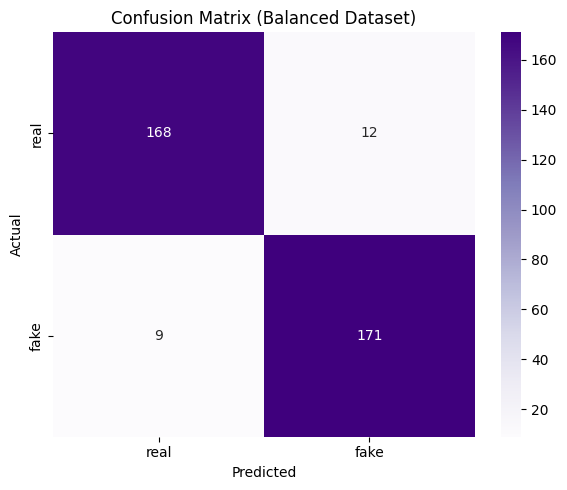

In [ ]:
#import libraries

from torchvision.datasets import ImageFolder
from PIL import UnidentifiedImageError
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import os

#skip corrupt images

class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except (UnidentifiedImageError, OSError, ValueError):
            print(f"Skipping corrupt image: {self.samples[index][0]}")
            return None

#load transformer

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
def transform_fn(image):
    encoding = processor(image.convert("RGB"), return_tensors="pt")
    return encoding["pixel_values"].squeeze(0)

transform = transforms.Compose([transforms.Lambda(transform_fn)])

#safe collate
def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return torch.empty(0), torch.empty(0, dtype=torch.long)
    imgs, labs = zip(*batch)
    return torch.stack(imgs), torch.tensor(labs, dtype=torch.long)

#load balanced test dataset

test_dir = "/content/drive/MyDrive/test_final"
full_ds = SafeImageFolder(root=test_dir, transform=transform)

print(" Detected classes:", full_ds.classes)
print(" Class-to-index mapping:", full_ds.class_to_idx)
#  Manually define correct label mapping
real_label = "realt"
fake_label = "faket"
real_idx = full_ds.class_to_idx[real_label]
fake_idx = full_ds.class_to_idx[fake_label]

print(f" Correct mapping: '{real_label}' = REAL, '{fake_label}' = FAKE")
readable_class_names = ["real", "fake"]


# Create test loader

test_loader = DataLoader(full_ds, batch_size=16, shuffle=False, num_workers=2, collate_fn=safe_collate)

#load trained model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)

checkpoint_path = "/content/drive/MyDrive/train_final/trained_vit_final.pth"
if os.path.exists(checkpoint_path):
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    print(" Trained model weights loaded.")
else:
    print(" ERROR: Trained model checkpoint not found!")

model.to(device)
model.eval()

#testing

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        if images.numel() == 0:
            continue
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=images)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


# Evaluation Metrics

print("\n Evaluation Complete")
print(f" Accuracy        : {accuracy_score(all_labels, all_preds):.4f}")
print(f" Macro F1 Score  : {f1_score(all_labels, all_preds, average='macro'):.4f}")
print(f" Micro F1 Score  : {f1_score(all_labels, all_preds, average='micro'):.4f}")
print("\n Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=readable_class_names))


#  CONFUSION MATRIX
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=readable_class_names,
            yticklabels=readable_class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Balanced Dataset)")
plt.tight_layout()
plt.show()

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=readable_class_names,
            yticklabels=readable_class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Balanced Dataset)")
plt.tight_layout()
plt.show()


**ROC CURVE**

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


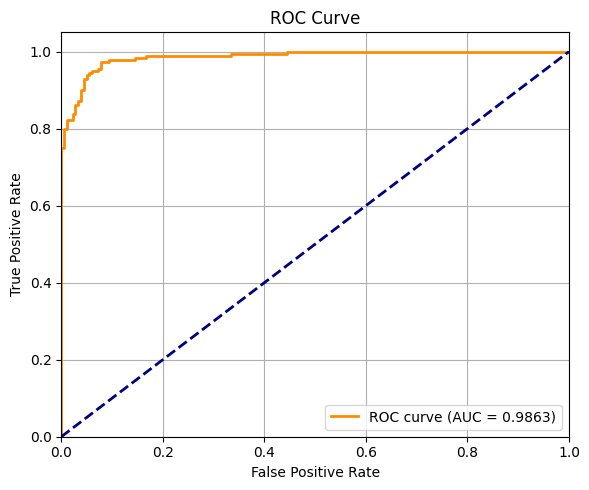

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch

# setup device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# skipping corrupt images

class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except (UnidentifiedImageError, OSError, ValueError):
            print(f"Skipping corrupt image: {self.samples[index][0]}")
            return None

def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return torch.empty(0), torch.empty(0, dtype=torch.long)
    imgs, labs = zip(*batch)
    return torch.stack(imgs), torch.tensor(labs, dtype=torch.long)

# transformer

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
def transform_fn(image):
    encoding = processor(image.convert("RGB"), return_tensors="pt")
    return encoding["pixel_values"].squeeze(0)
transform = transforms.Compose([transforms.Lambda(transform_fn)])

# load test data

test_dataset = SafeImageFolder("/content/drive/MyDrive/test_final", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, collate_fn=safe_collate)

#model

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
model.load_state_dict(torch.load("/content/drive/MyDrive/train_final/trained_vit_final.pth", map_location=device))
model.to(device)
model.eval()

#labelling

all_labels, all_probs = [], []

with torch.no_grad():
    for images, labels in test_loader:
        if images.numel() == 0:
            continue
        images = images.to(device)
        outputs = model(pixel_values=images)
        probs = torch.softmax(outputs.logits, dim=1)
        all_probs.extend(probs[:, 1].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ROC CURVE
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
